In [2]:
import os
import json
import pytz
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
USERS_TWEETS_DIR = os.path.join(ROOT_DIR, 'output', 'tweets', '2022-02-05')

keywords = {
    'covid': [
      'alemka', 'markotic', 'markotić', 'beros', 'beroš', 'capak', 'hzjz',
      
      'antigensk', 'antimaskeri', 'antivakseri',
      
      'cijep', 'cijepiv', 'cijeplj', 'cijepljen', 'cjep', 'cjepiv', 'cjepljen',
      
      'booster doza', 'prva doza', 'druga doza', 'treca doza', 'treća doza',
      'astra zeneca', 'biontech', 'curevac', 'inovio', 'janssen', 'johnson', 
      'novavax', 'moderna', 'pfizer', 'vaxart',
      
      'sojevi koronavirusa', 'brazilski', 'britanski', 'ceski soj', 'delta', 
      'indijski', 'juznoafricki', 'južnoafrički', 'lambda', 
      'njujorski',  'njujorški', 'omikorn', 'omikron', 'novi soj', 'češki soj'
      
      'coron', 'corona', 'covid', 'covid-19', 'covid 19', 'koron', 'korona', 'kovid', 
      'ncov', 'mutira', 'mutaci', 'n95', 'sars-cov-2', 'sarscov2', 'sputnik',
      
      'inkubacij', 'ljekov', 'obolje', 'novozaražen', 'nuspoj', 'patoge', 'regeneron', 
      'medicin', 'infekc', 'dezinf', 'bolnic', 'dijagnost', 'doktor', 'epidem', 
      'respir', 'respirator', 'simpto', 'rt pcr', 'terapij', 'viro', 'virus',
      
      'slusaj struku', 'slušaj struku', 'propusnic', 'ostani doma', 'ostanimo doma', 'zaraž', 
      'festivala slobod',  'pcr', 'samoizola','samoizolacij', 'testira', 'zaraz',
      'distanc', 'izolac', 'karant', 'lockd', 'mask', 'festival slobod', 
      'ostanimo odgovorni', 'pandem', 'pandemij', 'stozer', 'stožer',
    ]
}


if not os.path.exists('tweets.csv'):
    data = []
    for fn in os.listdir(USERS_TWEETS_DIR):
        with open(os.path.join(USERS_TWEETS_DIR, fn), 'r', encoding='utf-8') as f:
            content = json.load(f)
        for item in content:
            data.append({
                'id': item.get('id'),
                'user_id': item.get('user').get('id'),
                'full_text': item.get('full_text'),
                'created_at': item.get('created_at')
            })

    df = pd.DataFrame(data)
    df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y') # 30s
    df['week']  = df['created_at'].dt.strftime('%Y-%W')
    df['month'] = df['created_at'].dt.strftime('%Y-%m')
else:
    df = pd.read_csv('tweets.csv')
    df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S%z') # 30s

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796136 entries, 0 to 1796135
Data columns (total 8 columns):
 #   Column      Dtype              
---  ------      -----              
 0   Unnamed: 0  int64              
 1   id          int64              
 2   user_id     int64              
 3   full_text   object             
 4   created_at  datetime64[ns, UTC]
 5   week        object             
 6   month       object             
 7   is_covid    bool               
dtypes: bool(1), datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 97.6+ MB


In [31]:
print("Total # of Tweets:", len(df))
print("# of Tweets in 2022:", len(df[df['created_at'] > dt.datetime(2022, 1, 1, 0, 0, 0, 0, pytz.UTC)]))

df = df[
    (df['created_at'] > dt.datetime(2021, 8, 1, 0, 0, 0, 0, pytz.UTC))
    & (df['created_at'] < dt.datetime(2022, 1, 31, 0, 0, 0, 0, pytz.UTC))
]
print("# of Tweets from 2021-08-01 - 2022-02-01:", len(df))

Total # of Tweets: 6367710
# of Tweets in 2022: 489676
# of Tweets from 2021-08-01 - 2022-02-01: 1796136


In [32]:

df['is_covid'] = df['full_text'].transform(lambda x: any(
        isinstance(x, str) and (tag in x.lower()
        or tag.replace(' ', '') in x.replace(' ', ''))
    for tag in keywords['covid']))

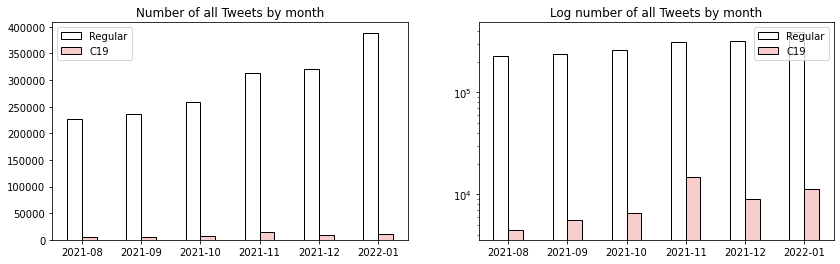

In [109]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))


df.groupby(['month', 'is_covid']).size().unstack('is_covid') \
    .plot.bar(
        title="Number of all Tweets by month", 
        rot=0,
        ax=ax[0],
        color=['#ffffff', '#f8cecc'],
        edgecolor='black'
    )
ax[0].legend(['Regular', 'C19'])
ax[0].set_xlabel(None)

df.groupby(['month', 'is_covid']).size().unstack('is_covid') \
    .plot.bar(
        title="Log number of all Tweets by month", 
        rot=0,
        ax=ax[1],
        color=['#ffffff', '#f8cecc'],
        edgecolor='black',
        logy=True
    )
ax[1].legend(['Regular', 'C19'])
ax[1].set_xlabel(None)

plt.show()

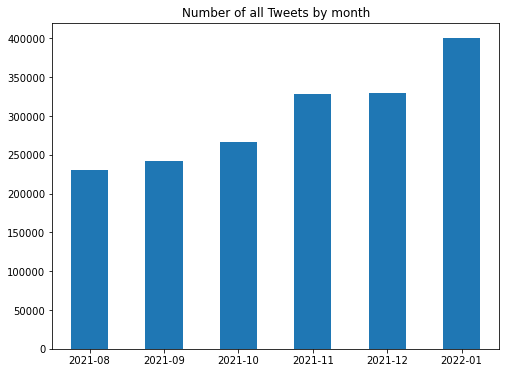

In [7]:
df.groupby('month').size().plot.bar(title="Number of all Tweets by month", rot=0, figsize=(8, 6))
plt.xlabel(None)
plt.show()

In [94]:
print("All Tweets:", len(df))
df.groupby('is_covid').size()

All Tweets: 1796136


is_covid
False    1744627
True       51509
dtype: int64

In [65]:
users_df = df.groupby('user_id').size().reset_index(name='total_tweets').set_index('user_id')
users_df['covid_tweets'] = df[df['is_covid'] == True].groupby('user_id').size()
users_df['is_covid'] = users_df['covid_tweets'].transform(lambda x: x > 0)
users_df['covid_tweets'] = users_df['covid_tweets'].fillna(0)
users_df['covid_pct'] = users_df['covid_tweets'] / users_df['total_tweets']

print("[all] Unique # of users:", len(users_df))
print("[all] Unique # of users with at least 5 Tweets:", len(users_df[users_df['total_tweets'] > 5]))

print("[at least 1 covid tweet] Unique # of users:", len(users_df[users_df['is_covid'] == True]))
print("[at least 1 covid tweet] Unique # of users with at least 5 Tweets:", len(users_df[(users_df['is_covid'] == True) & (users_df['total_tweets'] > 5)]))

users_df.sort_values(by='covid_pct', ascending=False).to_csv('user_tweets.csv')

[all] Unique # of users: 8809
[all] Unique # of users with at least 5 Tweets: 6110
[at least 1 covid tweet] Unique # of users: 3060
[at least 1 covid tweet] Unique # of users with at least 5 Tweets: 2935


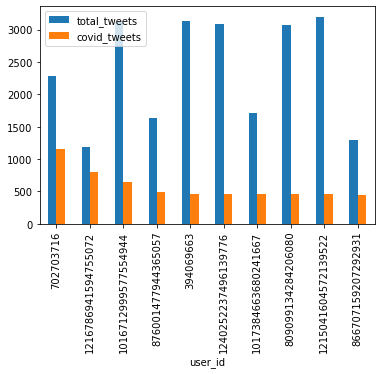

In [96]:
users_df[['total_tweets', 'covid_tweets']] \
    .sort_values(by='covid_tweets', ascending=False) \
    .head(10) \
    .plot.bar()

plt.show()

<AxesSubplot:ylabel='Frequency'>

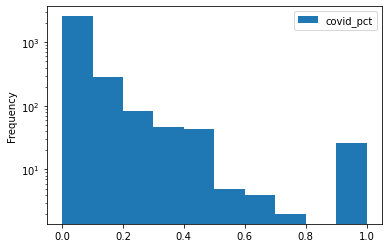

In [57]:
users_df[users_df['is_covid'] == True][['covid_pct']].plot.hist(logy=True)

In [103]:
users_friends = {}
for fn in os.listdir(os.path.join(ROOT_DIR, 'output', 'users', 'ids', '2022-02-04')):
    user_id_str = fn.replace('.json', '')
    if int(user_id_str) in users_df.index:
        fpath = os.path.join(ROOT_DIR, 'output', 'users', 'ids', '2022-02-04', fn)
        with open(fpath, 'r') as f:
            user = json.load(f).get(user_id_str)
            users_friends.update({user_id_str: {}})
            users_friends[user_id_str]['friends'] = list(filter(lambda x: x in users_df.index, user['friends']))
            users_friends[user_id_str]['followers'] = list(filter(lambda x: x in users_df.index, user['followers']))
            
        
with open('2021_08-2022_02-user_friends.json', 'w') as f:
    json.dump(users_friends, f, indent=2)

In [104]:
df.set_index('id').to_csv('2021_08-2022_02-tweets.csv', encoding='utf-8')
users_df.to_csv('2021_08-2022_02-user_tweets.csv', encoding='utf-8')